In [1]:
from __future__ import division, print_function
import sys
sys.path.insert(0, '..')
%matplotlib inline

In [2]:
import matplotlib as mpl
import seaborn as sns; sns.set_style('white')
import matplotlib.pyplot as plt
import numpy as np

from lavaburst import scoring, segment, sampling, utils
blues = sns.cubehelix_palette(0.4, gamma=0.5, rot=-0.3, dark=0.1, light=0.9, as_cmap=True)

In [3]:
def nice_ticks(ax, start, end, binsize, axis=(0,1), tick_params=None):
    from matplotlib.ticker import MaxNLocator, FuncFormatter
    tick_locator = MaxNLocator(5)
    tick_formatter = FuncFormatter(lambda x, pos: '{:,}'.format(int(start + x*binsize)))
    if axis == 0 or axis == (0,1):
        ax.xaxis.set_major_locator(tick_locator)
        ax.xaxis.set_major_formatter(tick_formatter)
    else:
        ax.set_xticks([])
    if axis == 1 or axis == (0,1):
        ax.yaxis.set_major_locator(tick_locator)
        ax.yaxis.set_major_formatter(tick_formatter)
    else:
        ax.set_yticks([])
    
    if tick_params is not None:
        ax.tick_params(**tick_params)

### Load your heatmap

In [4]:
A = np.loadtxt('IMR90_inSitu-all-MboI-hg19-chr11-0-20000000-balanced.tsv')
start = 0
end = 20000000
binsize = 10000
good_bins = A.astype(bool).sum(axis=0) > 100

At = utils.tilt_heatmap(A, n_diags=500)

### Create a score matrix and a segmentation model ###

In [5]:
S = scoring.modularity_score(A, gamma=6.0, binmask=good_bins)
model = segment.SegModel(S)

## Find the optimal segmentation ##

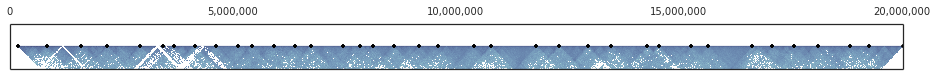

In [6]:
segments = model.optimal_segmentation()

f = plt.figure(figsize=(16, 2))
ax = f.add_subplot(111)
ax.matshow(np.log(At), cmap=blues)
for a,b in segments:
    ax.plot([a-0.5,b-0.5], [-1,-1], 'k.')
ax.set_xlim([0,len(A)])
ax.set_ylim([100,-100])
ax.set_aspect(np.sqrt(0.25))
nice_ticks(ax, start, end, binsize, axis=0)

## Domain boundary probabilities for all bin edges ##

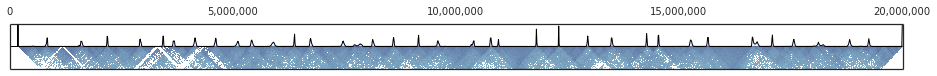

In [7]:
prob = model.boundary_marginals(beta=10000)

f = plt.figure(figsize=(16, 2))
ax = f.add_subplot(111)
ax.matshow(np.log(At), cmap=blues)
ax.plot(np.arange(len(prob))-0.5, -100*prob, 'k', lw=1)
ax.set_xlim([0,len(A)])
ax.set_ylim([100,-100])
ax.set_aspect(np.sqrt(0.25))
nice_ticks(ax, start, end, binsize, axis=0)

### Call peak regions ###

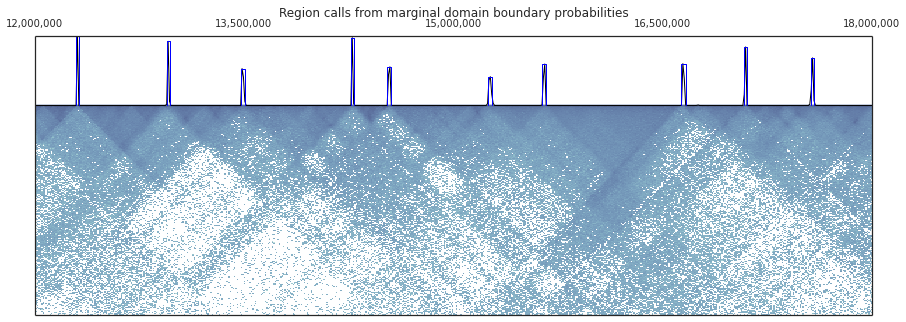

In [8]:
Pb = model.boundary_marginals(50000)
x,y,p = segment.call_boundary_peaks(Pb)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
ax.matshow(np.log(At), cmap=blues)
ax.plot(np.arange(len(Pb))-0.5, -100*Pb, 'k', lw=1)
for xx, yy, pp in zip(x,y,p):
    if pp > 0.1:
        ax.plot([xx-0.5, xx-0.5, yy-0.5, yy-0.5], [-1, -100*pp, -100*pp, -1], 'b', lw=1)
        
ax.set_title('Region calls from marginal domain boundary probabilities')
ax.set_xlim([1200, 1800])
ax.set_ylim([300, -100])
ax.set_aspect(np.sqrt(0.25))
nice_ticks(ax, start, end, binsize, axis=0)

## Domain probabilities for every segment ##

<matplotlib.colorbar.Colorbar instance at 0x7f5c657dfcf8>

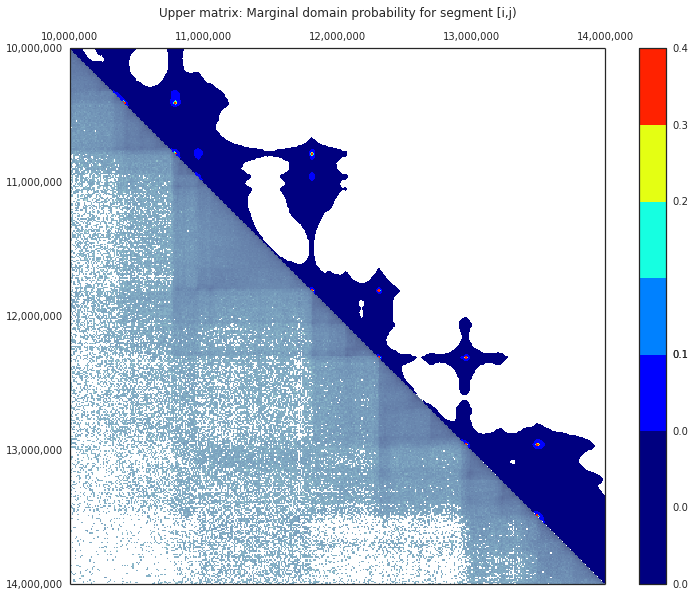

In [9]:
Ps = model.segment_marginals(50000)

f = plt.figure(figsize=(12,12))
ax = f.add_subplot(111)
ax.matshow(utils.reveal_tril(np.log(A)), cmap=blues)
cp = ax.contourf(
    utils.reveal_triu(Ps), 
    levels=[1e-100, 1e-50, 1e-10, 1e-1, 0.1, 0.2, 0.3, 0.4], 
    cmap=plt.cm.jet)
lo, hi = 1000, 1400
ax.set_xlim([lo,hi])
ax.set_ylim([hi,lo])
nice_ticks(ax, start, end, binsize)
ax.set_title('Upper matrix: Marginal domain probability for segment [i,j)')
f.colorbar(cp, shrink=0.8)

### Call peaks (domains) ###

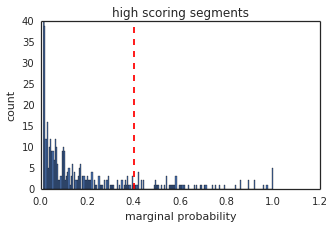

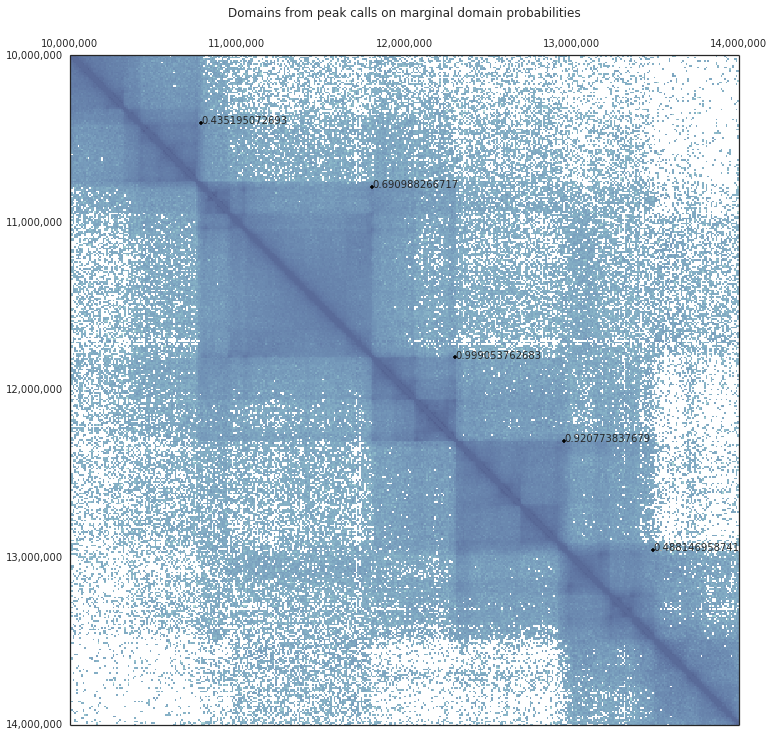

In [10]:
Ps = model.segment_marginals(50000)
thresh = 0.4

f = plt.figure(figsize=(5,3))
ax = f.add_subplot(111)
x = np.triu(Ps)
ax.hist(x[x>0.01].flat, bins=200)
ax.axvline(thresh, ls='--', color='r')
ax.set_title('high scoring segments')
ax.set_xlabel('marginal probability')
ax.set_ylabel('count')

x,y,p = segment.call_segment_peaks(Ps, thresh)
f = plt.figure(figsize=(12,12))
ax = f.add_subplot(111)
ax.matshow(np.log(A), cmap=blues)
ax.plot(y-0.5, x-0.5, 'k.')
lo, hi = 1000, 1400
for xx, yy, pp in zip(x, y, p):
    if (lo < xx < hi) and (lo < yy < hi):
        ax.text(yy, xx, pp)

ax.set_title('Domains from peak calls on marginal domain probabilities')        
ax.set_xlim([lo,hi])
ax.set_ylim([hi,lo])
nice_ticks(ax, start, end, binsize)
